In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from matplotlib.ticker import FuncFormatter

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [3]:
from alpha_vantage.timeseries import TimeSeries
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

Внесем основные акции (входящие в индекс МосБиржи) и облигации федерального займа

In [4]:
bonds_tickers = ['SU26207RMFS9', 'SU26212RMFS9', 'SU26218RMFS6', 'SU26219RMFS4', 
                 'SU26221RMFS0', 'SU26224RMFS4', 'SU26225RMFS1', 'SU26226RMFS9',
                 'SU26228RMFS5', 'SU26229RMFS3', 'SU26230RMFS1', 'SU26231RMFS9', 'SU26232RMFS7'] # тикеры облигаций

In [5]:
tickers = ['OZON', 'VKCO', 'GAZP', 'GMKN', 'CHMF', 'TATN', 'YNDX', 'HHRU', 'LKOH', 'MVID', 'MGNT', 
           'MTSS', 'ROSN', 'ENPG', 'TRUR', 'SBER', 'NVTK', 'SNGS', 'PHOR', 'NLMK', 'ALRS', 'AFLT', 
           'POSI', 'LIFE', 'FIXP', 'AFKS', 'AFLT', 'AGRO', 'ENPG', 'FEES', 'FIVE', 'HYDR', 'PIKK', 
           'POSI', 'SELG', 'SGZH', 'TCSG', 'VTBR', 'VEON-RX', 'SMLT', 'POLY', 'PLZL', 'SNGSP', 
           'LENT', 'MTLR', 'BELU', 'RENI', 'RTKM', 'RUAL', 'FLOT', 'ENPG', 'UPRO']

In [6]:
news = tickers + bonds_tickers

Загружаем котировки с отчетного периода с сайта мосбиржи

In [7]:
news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')

<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01'

<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01', end='2019-09-01')
<ipython-input-7-b0fbbe18c8d6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_quotes = pdr.data.DataReader(news, 'moex', start='2017-09-01'

Преобразование в нужный для EfficientFrontier формат

In [8]:
news_stocks = news_quotes.pivot_table(index='TRADEDATE', columns='SECID', values='CLOSE') #преобразование датафрейма

In [9]:
news_stocks.columns

Index(['AFKS', 'AFLT', 'AGRO', 'ALRS', 'BELU', 'CHMF', 'FEES', 'FIVE', 'GAZP',
       'GMKN', 'HYDR', 'LIFE', 'LKOH', 'MGNT', 'MTLR', 'MTSS', 'MVID', 'NLMK',
       'NVTK', 'PHOR', 'PIKK', 'PLZL', 'POLY', 'ROSN', 'RTKM', 'RUAL', 'SBER',
       'SELG', 'SNGS', 'SNGSP', 'SU26207RMFS9', 'SU26212RMFS9', 'SU26218RMFS6',
       'SU26219RMFS4', 'SU26221RMFS0', 'SU26224RMFS4', 'SU26225RMFS1',
       'SU26226RMFS9', 'SU26228RMFS5', 'SU26229RMFS3', 'SU26230RMFS1', 'TATN',
       'UPRO', 'VTBR', 'YNDX'],
      dtype='object', name='SECID')

In [10]:
news_stocks.head()

SECID,AFKS,AFLT,AGRO,ALRS,BELU,CHMF,FEES,FIVE,GAZP,GMKN,...,SU26224RMFS4,SU26225RMFS1,SU26226RMFS9,SU26228RMFS5,SU26229RMFS3,SU26230RMFS1,TATN,UPRO,VTBR,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2017-09-01,11.955,190.00,699.0,78.95,602.0,894.9,0.17735,NaN,117.40,9803.0,...,NaN,NaN,NaN,NaN,NaN,NaN,386.15,2.370,0.06345,1820.0
2017-09-04,12.545,193.25,690.0,77.00,610.0,904.5,0.17615,NaN,117.00,9746.0,...,NaN,NaN,NaN,NaN,NaN,NaN,385.40,2.350,0.06163,1833.0
2017-09-05,13.645,200.75,688.0,78.20,605.0,894.0,0.17295,NaN,116.00,9692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,386.00,2.319,0.06010,1863.0
2017-09-06,14.095,199.65,703.0,78.65,618.0,911.7,0.17260,NaN,117.14,9825.0,...,NaN,NaN,NaN,NaN,NaN,NaN,392.50,2.310,0.06020,1843.0
2017-09-07,13.815,197.05,709.0,78.50,NaN,905.0,0.17100,NaN,117.95,9660.0,...,NaN,NaN,NaN,NaN,NaN,NaN,389.40,2.294,0.06010,1820.0


In [11]:
mu_shares = expected_returns.mean_historical_return(news_stocks)
Sigma_shares = risk_models.sample_cov(news_stocks)

efficient_frontier = EfficientFrontier(mu_shares, Sigma_shares, weight_bounds=(0.01, 1)) #минимальный вес 0,01

max_sharpe = efficient_frontier.max_sharpe()

max_sharpe_pwt = efficient_frontier.clean_weights()

latest_prices = get_latest_prices(news_stocks)

allocation_max_sharpe, rem_max_sharpe = DiscreteAllocation(max_sharpe_pwt, latest_prices, total_portfolio_value=100000).lp_portfolio()

expected_return, volatility, sharpe_ratio = efficient_frontier.portfolio_performance(verbose=True)

print(allocation_max_sharpe)
print("Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа - {:.2f} рублей".format(rem_max_sharpe))
print("Ожидаемая доходность портфеля: {:.2%}".format(expected_return))
print("Волатильность портфеля: {:.2%}".format(volatility))
print("Коэффициент Шарпа портфеля: {:.4f}".format(sharpe_ratio))

c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


Expected annual return: 18.8%
Annual volatility: 7.8%
Sharpe Ratio: 2.16
{'AFKS': 86, 'AFLT': 9, 'AGRO': 1, 'ALRS': 13, 'BELU': 2, 'CHMF': 1, 'FEES': 5624, 'GAZP': 13, 'HYDR': 1816, 'LIFE': 212, 'LKOH': 1, 'MTLR': 17, 'MTSS': 4, 'MVID': 2, 'NLMK': 7, 'NVTK': 10, 'PIKK': 3, 'POLY': 1, 'ROSN': 3, 'RTKM': 12, 'RUAL': 38, 'SBER': 4, 'SELG': 107, 'SNGS': 36, 'SNGSP': 31, 'SU26207RMFS9': 9, 'SU26212RMFS9': 10, 'SU26218RMFS6': 9, 'SU26219RMFS4': 10, 'SU26221RMFS0': 10, 'SU26224RMFS4': 10, 'SU26225RMFS1': 10, 'SU26226RMFS9': 10, 'SU26228RMFS5': 379, 'SU26229RMFS3': 10, 'SU26230RMFS1': 9, 'TATN': 1, 'UPRO': 367, 'VTBR': 25804}
Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа - 4497.09 рублей
Ожидаемая доходность портфеля: 18.79%
Волатильность портфеля: 7.76%
Коэффициент Шарпа портфеля: 2.1640


c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
allocation_max_sharpe

{'AFKS': 86,
 'AFLT': 9,
 'AGRO': 1,
 'ALRS': 13,
 'BELU': 2,
 'CHMF': 1,
 'FEES': 5624,
 'GAZP': 13,
 'HYDR': 1816,
 'LIFE': 212,
 'LKOH': 1,
 'MTLR': 17,
 'MTSS': 4,
 'MVID': 2,
 'NLMK': 7,
 'NVTK': 10,
 'PIKK': 3,
 'POLY': 1,
 'ROSN': 3,
 'RTKM': 12,
 'RUAL': 38,
 'SBER': 4,
 'SELG': 107,
 'SNGS': 36,
 'SNGSP': 31,
 'SU26207RMFS9': 9,
 'SU26212RMFS9': 10,
 'SU26218RMFS6': 9,
 'SU26219RMFS4': 10,
 'SU26221RMFS0': 10,
 'SU26224RMFS4': 10,
 'SU26225RMFS1': 10,
 'SU26226RMFS9': 10,
 'SU26228RMFS5': 379,
 'SU26229RMFS3': 10,
 'SU26230RMFS1': 9,
 'TATN': 1,
 'UPRO': 367,
 'VTBR': 25804}

In [13]:
print(max_sharpe_pwt)

OrderedDict([('AFKS', 0.01), ('AFLT', 0.01), ('AGRO', 0.01), ('ALRS', 0.01), ('BELU', 0.01), ('CHMF', 0.01), ('FEES', 0.01), ('FIVE', 0.01), ('GAZP', 0.02909), ('GMKN', 0.01), ('HYDR', 0.01), ('LIFE', 0.01), ('LKOH', 0.04226), ('MGNT', 0.01), ('MTLR', 0.01), ('MTSS', 0.01), ('MVID', 0.01), ('NLMK', 0.01), ('NVTK', 0.12367), ('PHOR', 0.01), ('PIKK', 0.01), ('PLZL', 0.01), ('POLY', 0.01), ('ROSN', 0.01), ('RTKM', 0.01), ('RUAL', 0.01), ('SBER', 0.01), ('SELG', 0.01), ('SNGS', 0.01), ('SNGSP', 0.01), ('SU26207RMFS9', 0.01), ('SU26212RMFS9', 0.01), ('SU26218RMFS6', 0.01), ('SU26219RMFS4', 0.01), ('SU26221RMFS0', 0.01), ('SU26224RMFS4', 0.01), ('SU26225RMFS1', 0.01), ('SU26226RMFS9', 0.01), ('SU26228RMFS5', 0.39498), ('SU26229RMFS3', 0.01), ('SU26230RMFS1', 0.01), ('TATN', 0.01), ('UPRO', 0.01), ('VTBR', 0.01), ('YNDX', 0.01)])


Визуализация (сырая) по распределению весов инвестиционного портфеля

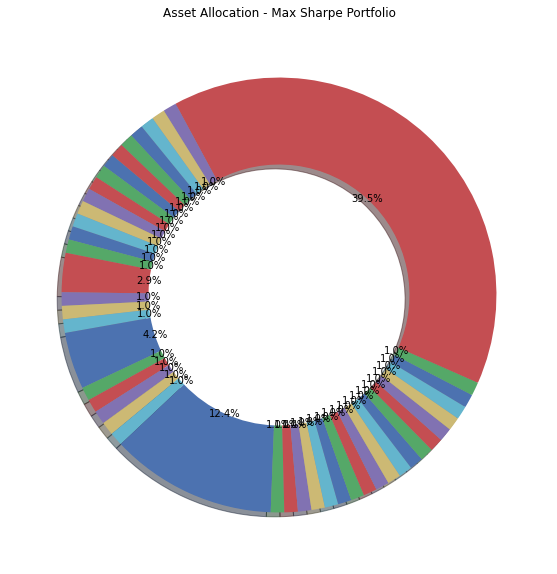

In [16]:
import matplotlib.pyplot as plt

labels = list(max_sharpe_pwt.keys())
values = list(max_sharpe_pwt.values())

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(values, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4), shadow=True)
ax.set_title('Asset Allocation - Max Sharpe Portfolio')

plt.show()